# **Methodology**

In this notebook, we explore hyperparameter tuning for the task of classifying malarial cells using Convolutional Neural Networks (CNNs). The goal is to enhance the original CNN model's performance by finding the optimal set of hyperparameters.

My approach can be summarized as follows:

1. **Data Preprocessing**: Same as in the original notebook.

2. **Model Architecture with Tunable Hyperparameters**: Redefine the CNN architecture to incorporate hyperparameters that Keras Tuner will optimize.

3. **Hyperparameter Tuning**: Utilize Keras Tuner to find the best hyperparameters for the CNN model.

4. **Evaluation**: Compare the tuned model's performance against the original model.




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Library and Module Imports**


In [2]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.5 MB/s eta 0:00:00


In [3]:
import sys
sys.path.append('/content/drive/My Drive/MalariaPred/Scripts')

import imports  # This will import all the modules and functions defined in imports.py

# Keras Tuner Notebook
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

# **Download Dataset from Kaggle**

* Upload the kaggle.json File to Colab:

In [4]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


* Move and Set Permissions for kaggle.json:

In [5]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
%run '/content/drive/My Drive/MalariaPred/Scripts/download_dataset.py'

Unzipping the dataset...
Dataset downloaded and extracted successfully.


# **Data Preprocessing and Loading**


In [7]:
import sys
sys.path.append('/content/drive/My Drive/MalariaPred')

# Import Image Processing utilities
from Utilities.image_processing import process_images_from_directory

In [8]:
# Define constants and initialize lists
BASE_PATH = imports.Path('/content/cell_images')

SIZE = 64
label = []
dataset = process_images_from_directory(BASE_PATH/'Parasitized', label, SIZE)
dataset.extend(process_images_from_directory(BASE_PATH/'Uninfected', label, SIZE))

* Data Exploratory Analysis (EDA)

In [9]:
# Import EDA utilities
from Utilities.eda_utils import display_samples, plot_class_distribution

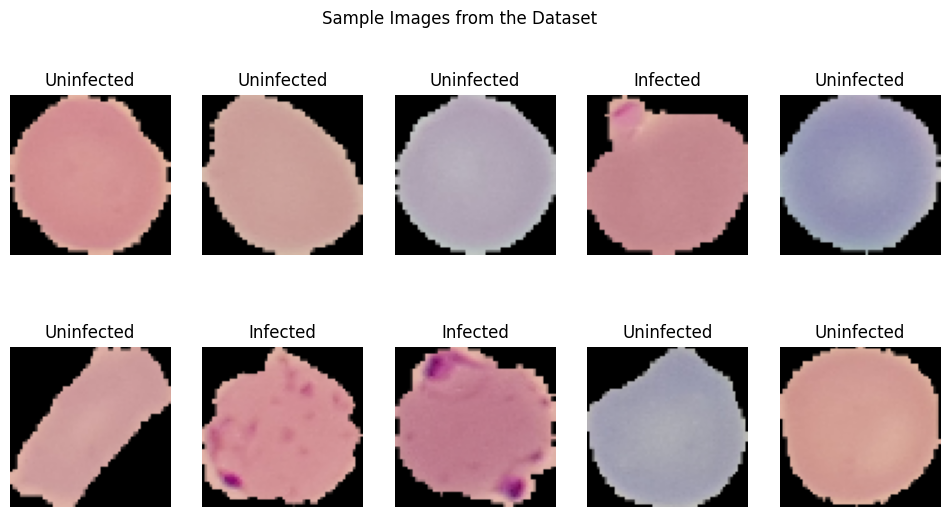

In [10]:
# Perform EDA
samples_to_display = 10

random_indices = imports.np.random.choice(len(dataset), samples_to_display, replace=False)
samples = [dataset[i] for i in random_indices]
sample_labels = [label[i] for i in random_indices]

# Example usage
display_samples(samples, sample_labels, "Sample Images from the Dataset")

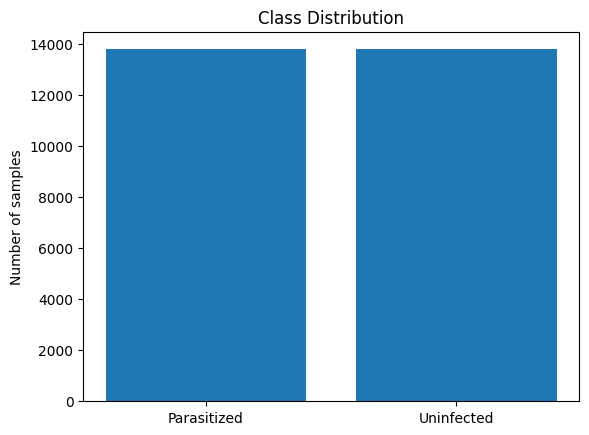

In [11]:
plot_class_distribution(label, "Class Distribution")

# **Model Architecture for Keras Tuner**


In [12]:
import keras

class MalariaHyperModel(imports.HyperModel):
    def build(self, hp):
        model = keras.Sequential()
        # Define a tunable number of convolutional layers
        for i in range(hp.Int('conv_layers', 2, 4)):
            model.add(imports.Conv2D(
                filters=hp.Choice(f'filters_{i}', [16, 32, 64]),
                kernel_size=(3, 3),
                activation='relu'
            ))
            model.add(imports.MaxPooling2D(pool_size=(2, 2)))
        model.add(imports.Flatten())
        # Define a tunable number of neurons in the dense layer
        model.add(imports.Dense(
            units=hp.Int('units', min_value=32, max_value=512, step=32),
            activation='relu'
        ))
        model.add(imports.Dense(2, activation='softmax'))
        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return model

#**Training & Validation**

* Prepare the Data

In [13]:
# Splitting the Dataset
X = imports.np.array(dataset)
Y = imports.to_categorical(imports.np.array(label))
X_train_val, X_test, y_train_val, y_test = imports.train_test_split(X, Y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val  = imports.train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)
# 60% training set, 20% validation set, 20% test set

In [14]:
# Convert and normalize the image data
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

* Data Augmentation

In [15]:
# Define the ImageDataGenerator
data_generator = imports.ImageDataGenerator(
    rotation_range    = 15,
    width_shift_range = 0.1,
    height_shift_range= 0.1,
    zoom_range        = 0.1,
    horizontal_flip   = True,
    vertical_flip     = True
)


# to create the augmented data generator
augmented_data = data_generator.flow(X_train, y_train, batch_size = 64)

In [16]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (22046, 64, 64, 3)
y_train shape: (22046, 2)
X_test shape: (5512, 64, 64, 3)
y_test shape: (5512, 2)


# **Hyperparameter Tuning with Keras Tuner**


In [17]:
import keras

tuner = imports.RandomSearch(
    MalariaHyperModel(),
    objective='val_accuracy',
    max_trials=8,
    executions_per_trial=2,
    directory='tuner_dir',
    project_name='malaria_tuning'
)

tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Trial 8 Complete [00h 02m 40s]
val_accuracy: 0.9584542810916901

Best val_accuracy So Far: 0.9589985609054565
Total elapsed time: 00h 21m 17s


In [18]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

In [19]:
early_stopping = imports.EarlyStopping(monitor='val_loss', patience=5)

# Training the Best Model from Tuner
history = best_model.fit(
    augmented_data,
    verbose=1,
    epochs=30,
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) // 64,  # Number of batches per epoch
    callbacks=[early_stopping]
)

Epoch 1/30
344/344 [==============================] - 51s 122ms/step - loss: 0.1712 - accuracy: 0.9451 - val_loss: 0.1309 - val_accuracy: 0.9568
Epoch 2/30
344/344 [==============================] - 37s 109ms/step - loss: 0.1653 - accuracy: 0.9453 - val_loss: 0.1288 - val_accuracy: 0.9581
Epoch 3/30
344/344 [==============================] - 34s 100ms/step - loss: 0.1626 - accuracy: 0.9479 - val_loss: 0.1309 - val_accuracy: 0.9579
Epoch 4/30
344/344 [==============================] - 35s 101ms/step - loss: 0.1563 - accuracy: 0.9492 - val_loss: 0.1271 - val_accuracy: 0.9583
Epoch 5/30
344/344 [==============================] - 35s 101ms/step - loss: 0.1522 - accuracy: 0.9505 - val_loss: 0.1287 - val_accuracy: 0.9577
Epoch 6/30
344/344 [==============================] - 34s 100ms/step - loss: 0.1521 - accuracy: 0.9501 - val_loss: 0.1377 - val_accuracy: 0.9543
Epoch 7/30
344/344 [==============================] - 35s 101ms/step - loss: 0.1498 - accuracy: 0.9510 - val_loss: 0.1253 - val_ac

In [20]:
# Evaluate the model
scores = best_model.evaluate(imports.np.array(X_test), imports.np.array(y_test), verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
print(f"Test Loss: {scores[0]:.5f}")

# Predict classes with the model
predictions = best_model.predict(imports.np.array(X_test))
predicted_classes = imports.np.argmax(predictions, axis=1)

# Convert one-hot encoded labels to single-column format
y_test_single_column = imports.np.argmax(y_test, axis=1)

# Generate classification report and confusion matrix
print(imports.classification_report(y_test_single_column, predicted_classes))
print(imports.confusion_matrix(y_test_single_column, predicted_classes))

Accuracy: 96.08%
Test Loss: 0.10908
173/173 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2797
           1       0.95      0.97      0.96      2715

    accuracy                           0.96      5512
   macro avg       0.96      0.96      0.96      5512
weighted avg       0.96      0.96      0.96      5512

[[2665  132]
 [  84 2631]]


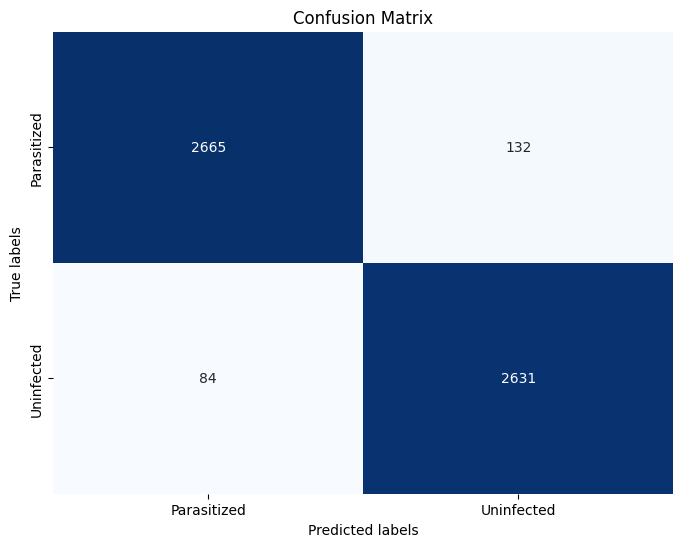

In [21]:
# Calculate the confusion matrix
conf_matrix = imports.confusion_matrix(y_test_single_column, predicted_classes)

import seaborn as sns
import matplotlib.pyplot as plt

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5], labels=['Parasitized', 'Uninfected'])
plt.yticks(ticks=[0.5, 1.5], labels=['Parasitized', 'Uninfected'])
plt.show()


In [22]:
# Calculate the average training loss over all epochs
average_train_loss = imports.np.mean(history.history['loss'])

# Get the training loss from the last epoch
final_train_loss = history.history['loss'][-1]

print(f"Average Training Loss: {average_train_loss:.5f}")
print(f"Final Training Loss: {final_train_loss:.5f}")

Average Training Loss: 0.13902
Final Training Loss: 0.12450


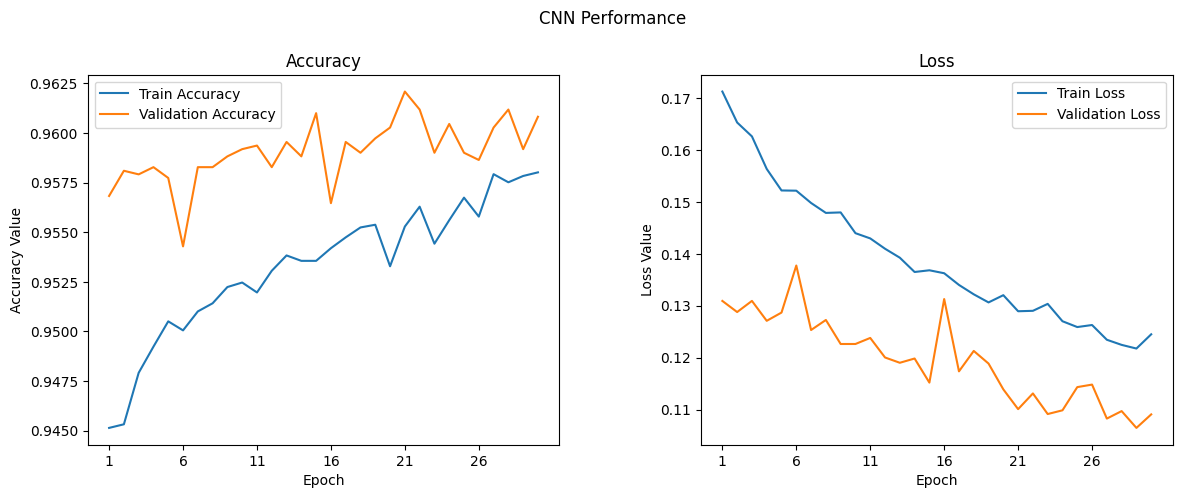

In [23]:
def plot_training_history(history):
    """
    Plot the training and validation accuracy and loss over epochs.

    This function visualizes the model's training progress. It plots two graphs:
    - The first graph shows the training and validation accuracy over epochs.
    - The second graph shows the training and validation loss over epochs.

    Parameters:
    - history: A Keras History object containing the model's training history.

    The function creates a subplot with two axes objects and plots the accuracy and
    loss values stored in the history object.
    """

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('CNN Performance', fontsize=12)
    fig.subplots_adjust(top=0.85, wspace=0.3)

    # Extract the number of epochs and create a list of epoch numbers
    max_epoch = len(history.history['accuracy'])
    epoch_list = list(range(1, max_epoch + 1))

    # Plot training and validation accuracy
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(imports.np.arange(1, max_epoch + 1, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    ax1.legend(loc="best")

    # Plot training and validation loss
    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(imports.np.arange(1, max_epoch + 1, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    ax2.legend(loc="best")

    # Display the plots
    plt.show()

# Call the function to plot
plot_training_history(history)

**Evaluating Model Discrimination Power**

In [32]:
# Get the predicted probabilities for the positive class (1)
y_pred_probs = best_model.predict(X_test)[:, 1]  # Assuming the second neuron corresponds to the positive class

173/173 [==============================] - 1s 3ms/step


In [26]:
from sklearn.metrics import roc_curve, auc

# Calculate the Receiver Operating Characteristic (ROC) curve
fpr, tpr, thresholds = roc_curve(y_test_single_column, y_pred_probs)

# Calculate the Area Under the ROC Curve (AUC) score
roc_auc = auc(fpr, tpr)
print(f'AUC Score: {roc_auc:.2f}')

AUC Score: 0.99


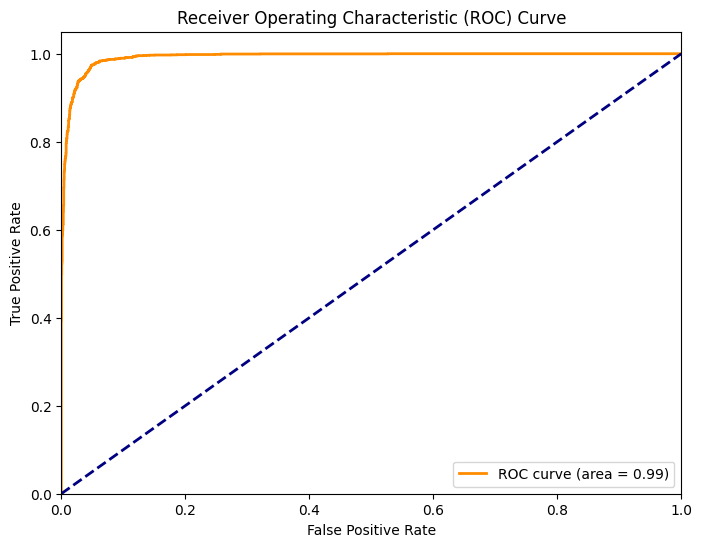

In [27]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

**Archiving the Model**

In [31]:
import os

# Define the model directory
model_dir = '/content/drive/My Drive/MalariaPred/Models'

# Ensure the directory exists
os.makedirs(model_dir, exist_ok=True)

# Save the model
model_path = os.path.join(model_dir, 'malaria_cnn_tunned.h5')
best_model.save(model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Visual Inspection of Model Predictions**

1/1 [==============================] - 0s 124ms/step


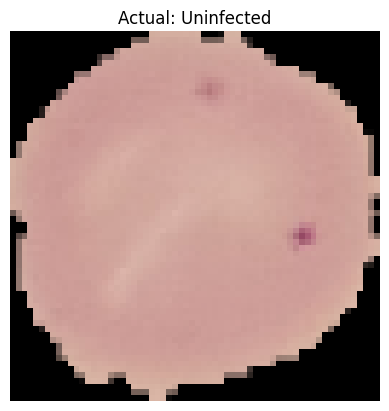

Predicted: Uninfected


In [30]:
# Define a mapping from class indices to human-readable class names
class_mapping = {0: "Infected", 1: "Uninfected"}

# Randomly pick an index from the test set
sample_index = imports.np.random.choice(len(X_test))
# Retrieve the corresponding image and label from the test set
sample_image = X_test[sample_index]
sample_label = y_test[sample_index]  # Use sample_index to retrieve the label

# Generate model predictions for the sample image
predictions = best_model.predict(imports.np.expand_dims(sample_image, axis=0))

# Determine the actual and predicted classes
actual_class = imports.np.argmax(sample_label)
predicted_class_idx = imports.np.argmax(predictions, axis=1)[0]

# Display the sample image
plt.imshow(sample_image)
# Title with the actual class
plt.title(f"Actual: {class_mapping[actual_class]}")
plt.axis("off")  # Hide the axis to focus on the image
plt.show()

# Print the predicted class
print(f"Predicted: {class_mapping[predicted_class_idx]}")
